In [ ]:
!pip install hmmlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.1/161.1 kB 6.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import pipeline
from sklearn.model_selection import train_test_split
from hmmlearn import hmm
import torch
from datasets import load_dataset


In [ ]:
# Step 1: Load the dataset from the local file (adjust the path to your file)
data = pd.read_csv('/content/hc3_train.csv')

# Focus on Chatgpt_answers and Human_answers
data = data[['chatgpt_answers', 'human_answers']]

# Create a combined dataset with labels (0 for human, 1 for ChatGPT)
data_human = pd.DataFrame({'text': data['human_answers'], 'label': 0})
data_chatgpt = pd.DataFrame({'text': data['chatgpt_answers'], 'label': 1})

combined_data = pd.concat([data_human, data_chatgpt]).reset_index(drop=True)

In [ ]:
# Step 2: Use HMM for stylistic segmentation
def sentence_lengths(text):
    return np.array([len(sentence.split()) for sentence in text.split('.') if sentence])

# Extract sentence lengths for HMM segmentation
combined_data['sentence_lengths'] = combined_data['text'].apply(sentence_lengths)

# Train a simple HMM to identify stylistic segments
hmm_model = hmm.GaussianHMM(n_components=2)
X = np.concatenate(combined_data['sentence_lengths'].values).reshape(-1, 1)
hmm_model.fit(X)

# Predict segments for each text using HMM
combined_data['hmm_segments'] = combined_data['sentence_lengths'].apply(lambda x: hmm_model.predict(x.reshape(-1, 1)))


In [ ]:
# Step 3: Use BERT for classification
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Split the data into train and test
train_texts, test_texts, train_labels, test_labels = train_test_split(combined_data['text'], combined_data['label'], test_size=0.2, random_state=42)

# Tokenize train and test texts
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, max_length=128)

# Create PyTorch datasets
class AuthorAttributionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = AuthorAttributionDataset(train_encodings, train_labels.values)
test_dataset = AuthorAttributionDataset(test_encodings, test_labels.values)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Step 4: Fine-tune BERT with the training data
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

trainer.train()

Step,Training Loss
10,0.689200
20,0.701300
30,0.655300
40,0.618100
50,0.577700
60,0.538700
70,0.474200
80,0.422800
90,0.416300
100,0.329800


Step,Training Loss
10,0.689200
20,0.701300
30,0.655300
40,0.618100
50,0.577700
60,0.538700
70,0.474200
80,0.422800
90,0.416300
100,0.329800


TrainOutput(global_step=7299, training_loss=0.03201931906755259, metrics={'train_runtime': 2750.2685, 'train_samples_per_second': 42.449, 'train_steps_per_second': 2.654, 'total_flos': 7679225039500800.0, 'train_loss': 0.03201931906755259, 'epoch': 3.0})

In [ ]:
# Step 5: Evaluate the model
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)


In [ ]:
# prompt: i want to get the accuracy of the model

from sklearn.metrics import accuracy_score

accuracy = accuracy_score(test_labels, preds)
print(f"Accuracy: {accuracy}")


Accuracy: 0.990440949737897


In [ ]:
# prompt: i want to get all the metrices such as loss, test  accuracy etc

import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# ... (your existing code) ...

# Step 5: Evaluate the model and get metrics
eval_results = trainer.evaluate()

# Extract metrics from the evaluation results
loss = eval_results['eval_loss']
accuracy = eval_results['eval_accuracy']

# Get predictions for calculating other metrics
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)

precision = precision_score(test_labels, preds)
recall = recall_score(test_labels, preds)
f1 = f1_score(test_labels, preds)

# Print the evaluation metrics
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,0.000000,0.055083,0.991366,0.991507,0.983353,0.999796


Loss: 0.05508297681808472
Accuracy: 0.9913660191181005
Precision: 0.9833533894905736
Recall: 0.9997960848287113
F1-Score: 0.9915065722952477


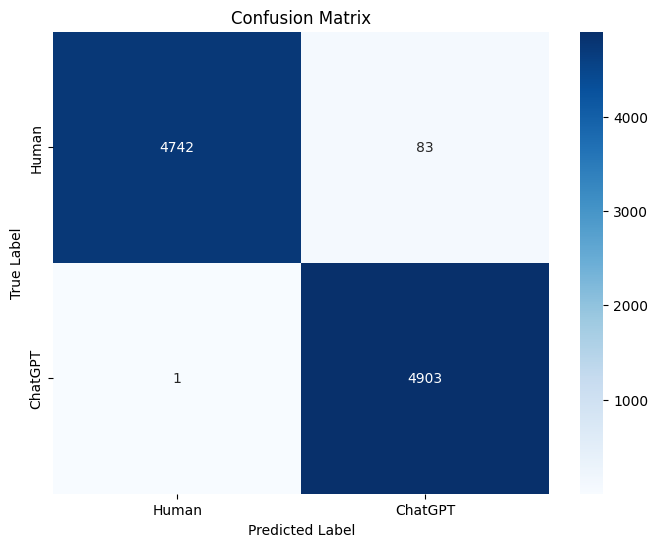

In [ ]:
# prompt: i want confusion matrix

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have 'preds' (predicted labels) and 'test_labels' (true labels)
cm = confusion_matrix(test_labels, preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Human', 'ChatGPT'], yticklabels=['Human', 'ChatGPT'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from google.colab import drive
import joblib
drive.mount('/content/drive')
# Save HMM model to Google Drive
joblib.dump(hmm_model, '/content/drive/My Drive/hmm_model.pkl')

# Save BERT model to Google Drive
model.save_pretrained('/content/drive/My Drive/bert_model')
tokenizer.save_pretrained('/content/drive/My Drive/bert_model')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


('/content/drive/My Drive/bert_model/tokenizer_config.json',
 '/content/drive/My Drive/bert_model/special_tokens_map.json',
 '/content/drive/My Drive/bert_model/vocab.txt',
 '/content/drive/My Drive/bert_model/added_tokens.json')

In [ ]:
# prompt: i want to save my model in a pickel file

import pickle

# Assuming 'model' is your trained model object
with open('/content/drive/My Drive/my_model.pkl', 'wb') as f:
  pickle.dump(model, f)


In [2]:
# prompt: give code for this
# i will give text to the model and it must predict it , include all the preprocessing steps too
import numpy as np
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import joblib


# Load the saved HMM model from Google Drive
hmm_model = joblib.load(r'C:\Users\91912\Desktop\DOcs\PR\project\hmm_model.pkl')


# Load the saved BERT model and tokenizer from Google Drive
tokenizer = BertTokenizer.from_pretrained(r'C:\Users\91912\Desktop\DOcs\PR\project\bert')
model = BertForSequenceClassification.from_pretrained(r'C:\Users\91912\Desktop\DOcs\PR\project\bert')


def sentence_lengths(text):
    return np.array([len(sentence.split()) for sentence in text.split('.') if sentence])


def classify_with_segments(text, segments):
    tokens = tokenizer(text, truncation=True, padding=True, return_tensors="pt")
    output = model(**tokens)
    predictions = torch.argmax(output.logits, dim=1).item()
    return predictions


def predict_author(text):
  # Preprocess: Extract sentence lengths for HMM segmentation
  sentence_lens = sentence_lengths(text)
  if sentence_lens.shape[0] > 0:
    # Predict segments using HMM
    segments = hmm_model.predict(sentence_lens.reshape(-1, 1))
    print(segments)

    # Classify using BERT with segments
    prediction = classify_with_segments(text, segments)

    # Post-processing (optional)

    return prediction
  else:
    return 0 # Or handle empty input as needed


# Example usage:
new_text = "Hyperparameter tuning with GridSearchCV can be time-intensive, especially with a large dataset and a broad parameter grid. One way to accelerate the process is to limit the number of parameters considered or switch to RandomizedSearchCV, which samples parameter combinations randomly to cut down on computation. Another strategy is to work with a reduced dataset or decrease the number of cross-validation folds to make the process faster. Leveraging parallel processing or increasing cache size, particularly when using SVM with kernel functions, can also significantly enhance the efficiency and reduce the time required for tuning."
prediction = predict_author(new_text)

if prediction == 0:
  print("Predicted author: Human")
else:
  print("Predicted author: ChatGPT")


[0 0 0 0]
Predicted author: ChatGPT


In [ ]:
!pip install hmmlearn
import numpy as np
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import joblib
from sklearn.metrics import accuracy_score

# Load the saved HMM model from Google Drive
hmm_model = joblib.load('/content/drive/My Drive/hmm_model.pkl')

# Load the saved BERT model and tokenizer from Google Drive
tokenizer = BertTokenizer.from_pretrained('/content/drive/My Drive/bert_model')
model = BertForSequenceClassification.from_pretrained('/content/drive/My Drive/bert_model')

# Function to get sentence lengths for HMM input
def sentence_lengths(text):
    return np.array([len(sentence.split()) for sentence in text.split('.') if sentence])

# Function to classify text using BERT and HMM-predicted segments
def classify_with_segments(text, segments):
    tokens = tokenizer(text, truncation=True, padding=True, return_tensors="pt")
    output = model(**tokens)
    predictions = torch.argmax(output.logits, dim=1).item()
    return predictions

# Main function to predict the author using HMM + BERT
def predict_author(text):
    # Preprocess: Extract sentence lengths for HMM segmentation
    sentence_lens = sentence_lengths(text)
    if sentence_lens.shape[0] > 0:
        # Predict segments using HMM
        segments = hmm_model.predict(sentence_lens.reshape(-1, 1))

        # Classify using BERT with segments
        prediction = classify_with_segments(text, segments)

        # Post-processing (optional)
        return prediction
    else:
        return 0  # Handle empty input

# Load the CSV file
csv_file_path = '/content/article_level_data.csv'  # Update this with the actual path
df = pd.read_csv(csv_file_path)
true_labels = df['class']
predictions = []

for text in df['article']:
    prediction = predict_author(text)
    predictions.append(prediction)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)

print(f"Total Accuracy: {accuracy * 100:.2f}%")


Total Accuracy: 94.20%
